In [22]:
import torch

import torch.optim as optim

import numpy as np

from tqdm import tqdm

from data.loader import load_amazon
from modules.rq_vae import RQ_VAE

In [23]:
batch_size = 256
normalize_data = False
train_loader, data_clean = load_amazon(category='beauty', batch_size=batch_size, normalize_data=normalize_data)

input_dimension = train_loader.dataset.shape[1]
hidden_dimension = [input_dimension, 512, 256]
latent_dimension = 256

num_codebook_layers = 3
codebook_clusters = 256
commitment_weight = 0.25

learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 2000

In [24]:
model = RQ_VAE(
        input_dim = input_dimension,
        latent_dim = latent_dimension,
        hidden_dims = hidden_dimension,
        codebook_size = codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = num_codebook_layers,
        commitment_weight = commitment_weight,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [25]:
def train(model, train_loader, optimizer, num_epochs):
    model.train()
    
    epoch_progress = tqdm(range(num_epochs), total=num_epochs, desc="Training")
    results = []
    
    for epoch in epoch_progress:
        total_loss = 0
        total_reconstruction_loss = 0
        total_commit_loss = 0
        p_unique = 0
        if(epoch == 0):
            kmeans_init_data = torch.Tensor(data_clean[torch.arange(min(20000, len(data_clean)))]).to(device, dtype=torch.float32)
            model(kmeans_init_data)
            
        for batch in train_loader:
            batch = batch.to(device).float()
            optimizer.zero_grad()
            result = model(batch)
            result.loss.backward()
            optimizer.step()
            
            total_loss += result.loss.item()
            total_reconstruction_loss += result.reconstruction_loss.item()
            total_commit_loss += result.rqvae_loss.item()
            p_unique += result.p_unique_ids.item()
        epoch_stats = {"Epoch": epoch,
                        "Loss": total_loss / len(train_loader),
                        "Reconstruction Loss": total_reconstruction_loss / len(train_loader),
                        "Commitment Loss": total_commit_loss / len(train_loader),
                        "Prob Unique IDs": p_unique / len(train_loader)}
        epoch_progress.set_postfix(epoch_stats)
        results.append(epoch_stats)
    return results

In [26]:
losses = train(model, train_loader, optimizer, num_epochs)

Training: 100%|██████████| 2000/2000 [16:04<00:00,  2.07it/s, Epoch=1999, Loss=210, Reconstruction Loss=163, Commitment Loss=46.8, Prob Unique IDs=1]      


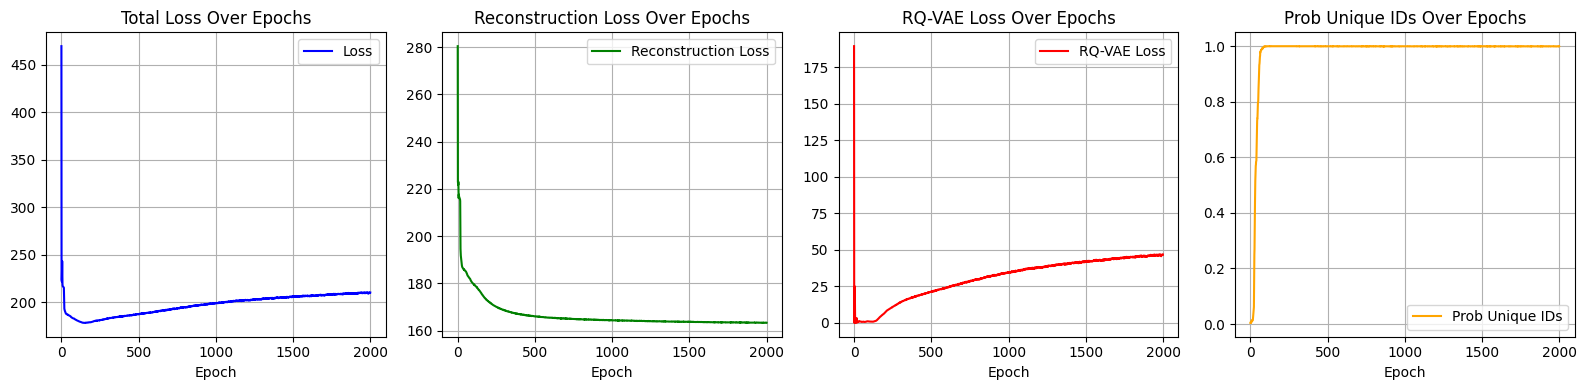

In [27]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharex=True)
# Loss
axs[0].plot(
    [item['Epoch'] for item in losses],
    [item['Loss'] for item in losses],
    label='Loss',
    color='blue'
)
axs[0].set_xlabel("Epoch")
axs[0].set_title("Total Loss Over Epochs")
axs[0].legend()
axs[0].grid(True)

# RQ-VAE Loss
axs[1].plot(
    [item['Epoch'] for item in losses],
    [item['Reconstruction Loss'].cpu().item() if hasattr(item['Reconstruction Loss'], 'cpu') else item['Reconstruction Loss'] for item in losses],
    label='Reconstruction Loss',
    color='green'
)
axs[1].set_xlabel("Epoch")
axs[1].set_title("Reconstruction Loss Over Epochs")
axs[1].legend()
axs[1].grid(True)

# Reconstruction Loss
axs[2].plot(
    [item['Epoch'] for item in losses],
    [item['Commitment Loss'].cpu().item() if hasattr(item['Commitment Loss'], 'cpu') else item['Commitment Loss'] for item in losses],
    label='RQ-VAE Loss',
    color='red'
)
axs[2].set_xlabel("Epoch")
axs[2].set_title("RQ-VAE Loss Over Epochs")
axs[2].legend()
axs[2].grid(True)

# Reconstruction Loss
axs[3].plot(
    [item['Epoch'] for item in losses],
    [item['Prob Unique IDs'].cpu().item() if hasattr(item['Prob Unique IDs'], 'cpu') else item['Prob Unique IDs'] for item in losses],
    label='Prob Unique IDs',
    color='orange'
)
axs[3].set_xlabel("Epoch")
axs[3].set_title("Prob Unique IDs Over Epochs")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [28]:
sem_ids = []

for datapoint in tqdm(data_clean, desc="Getting semantic ids"):
    product = torch.tensor(datapoint).to(device).float()
    
    with torch.no_grad():
        sem_id = model.get_semantic_id_single(product)
        sem_ids.append(sem_id)
        
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)
np.unique([x.cpu() for x in sem_ids], axis=0, return_counts=True)

Getting semantic ids:   0%|          | 0/12101 [00:00<?, ?it/s]

C:\Users\Justin\AppData\Local\Temp\ipykernel_31612\2058428087.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  product = torch.tensor(datapoint).to(device).float()
Getting semantic ids: 100%|██████████| 12101/12101 [00:22<00:00, 535.50it/s]


(array([[  0,  31,  61],
        [  0,  37, 187],
        [  0,  50, 130],
        ...,
        [255, 244, 153],
        [255, 252,  25],
        [255, 252, 252]]),
 array([1, 1, 1, ..., 1, 1, 1]))